In [1]:
import sys
import datetime
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

assert sys.version_info >= (3, 5) # make sure we have Python 3.5+

from pyspark.sql import SparkSession, functions, types
spark = SparkSession.builder.appName('tmax model tester').getOrCreate()
assert spark.version >= '2.3' # make sure we have Spark 2.3+
spark.sparkContext.setLogLevel('WARN')

from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import RegressionEvaluator


tmax_schema = types.StructType([
    types.StructField('station', types.StringType()),
    types.StructField('date', types.DateType()),
    types.StructField('latitude', types.FloatType()),
    types.StructField('longitude', types.FloatType()),
    types.StructField('elevation', types.FloatType()),
    types.StructField('tmax', types.FloatType()),
])

tempdiff count is:  239


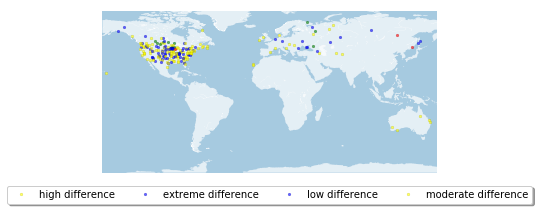

In [6]:
df = spark.read.csv('tmax-2/*.csv',tmax_schema)
df1 = df[df['date']<datetime.date(1950,1,1)]
df11 = df1.groupBy(df1.station).agg(functions.max(df1.date).alias("datemax"))
df11 = df11.withColumnRenamed('station', 'station1')
dfnew1 = df1.join(df11,[(df1.station==df11.station1)&(df1.date==df11.datemax)])
df_pre = dfnew1.select(dfnew1.station,dfnew1.date,dfnew1.latitude,dfnew1.longitude,dfnew1.elevation,dfnew1.tmax)

df2 = df[df['date']>=datetime.date(1950,1,1)]
df22 = df2.groupBy(df2.station).agg(functions.max(df2.date).alias("datemax"))
df22 = df22.withColumnRenamed('station', 'station1')
dfnew2 = df2.join(df22,[(df2.station==df22.station1)&(df2.date==df22.datemax)])
df_post = dfnew2.select(dfnew2.station,dfnew2.date,dfnew2.latitude,dfnew2.longitude,dfnew2.elevation,dfnew2.tmax)

oldlat = df1.select("latitude").rdd.map(lambda x: x.latitude).collect()
oldlong = df1.select("longitude").rdd.map(lambda x: x.longitude).collect()
dates = df.select("date").rdd.map(lambda x: x.date).collect()
newlat = df2.select("latitude").rdd.map(lambda x: x.latitude).collect()
newlong = df2.select("longitude").rdd.map(lambda x: x.longitude).collect()



df_pre = df_pre.withColumnRenamed('station', 'station1')
df_pre = df_pre.withColumnRenamed('tmax', 'tmax_pre')
df_pre = df_pre.withColumnRenamed('date', 'date_pre')
df_pre = df_pre.withColumnRenamed('latitude', 'latitude_pre')
df_pre = df_pre.withColumnRenamed('longitude', 'longitude_pre')
df_pre = df_pre.withColumnRenamed('elevation', 'elevation_pre')

df_pre.registerTempTable("df_pre")
df_post.registerTempTable("df_post")
df_common = spark.sql("select * from df_pre inner join df_post on df_pre.station1 == df_post.station")
df_main = df_common.select(df_common.station,df_common.date_pre,df_common.date,df_common.latitude,df_common.longitude,df_common.elevation,df_common.tmax_pre,df_common.tmax)
df_main = df_main.withColumn("temp_diff",functions.abs(df_main.tmax-df_main.tmax_pre))

latz = df_main.select("latitude").rdd.map(lambda x: x.latitude).collect()
longz = df_main.select("longitude").rdd.map(lambda x: x.longitude).collect()
tempdiff = df_main.select("temp_diff").rdd.map(lambda x: x.temp_diff).collect()
print("tempdiff count is: ",len(tempdiff))



marker_string = []
legend_string = []
for i in tempdiff:
    # Returns green for small earthquakes, yellow for moderate
    #  earthquakes, and red for significant earthquakes.
    if i >= min(tempdiff) and i < (max(tempdiff)/4):
        marker_string.append('yellow')
        legend_string.append('low difference')
    elif i >= (max(tempdiff)/4) and i < (max(tempdiff)/2):
        marker_string.append('blue')
        legend_string.append('moderate difference')
    elif i >= (max(tempdiff)/2) and i < ((3*max(tempdiff))/4):
        marker_string.append('green')
        legend_string.append('high difference')
    else:
        marker_string.append('red')
        legend_string.append('extreme difference')

        
        
m=Basemap(llcrnrlon=-160, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80, resolution='l')
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='white', alpha=0.7, lake_color='white')
m.drawcoastlines(linewidth=0.1, color="white")

for x, y, z in zip(longz, latz, marker_string):
    m.plot(x, y, linestyle='none', marker="o", markersize=3, alpha=0.6, color=z, markeredgecolor="black", markeredgewidth=0.1)
plt.legend(set(legend_string),loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.savefig('map.png')

+-----------+-------+--------+---------+---------+----+------------------+-------------------+
|    station|dayofyr|latitude|longitude|elevation|tmax|        prediction|          temp_diff|
+-----------+-------+--------+---------+---------+----+------------------+-------------------+
|AE000041196|    265|  25.333|   55.517|     34.0|37.2|30.486833435585726|  6.713167327353727|
|AEM00041194|    152|  25.255|   55.364|     10.4|35.6| 31.64042737194095|  3.959571102180142|
|AG000060390|    365| 36.7167|     3.25|     24.0|16.3|13.039056071341452| 3.2609431657190946|
|AGE00135039|    152| 35.7297|     0.65|     50.0|20.0|28.964440615828984|  8.964440615828984|
|AGE00147705|    243|   36.78|     3.07|     59.0|33.0|29.936785342989186|  3.063214657010814|
|AGE00147713|    335|   36.18|      5.4|   1081.0|11.0| 11.32731632149731|0.32731632149731027|
|AGE00147717|    213|    35.2|     0.63|    476.0|35.0| 29.84932654947668|  5.150673450523321|
|AGE00147718|     31|   34.85|     5.72|    125.0|

9225
diff count is  9225
diff distict count is  8810
reached 2


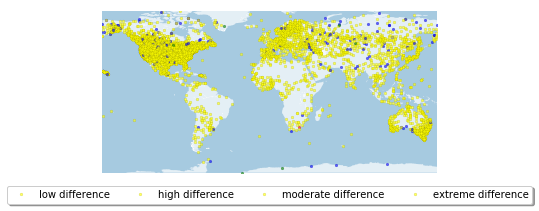

In [10]:
test_tmax = spark.read.csv('tmax-test/*.csv', schema=tmax_schema)
model_file = 'weather_model_final'
model = PipelineModel.load(model_file)
pred_df = model.transform(test_tmax)
pred_df = pred_df.withColumn("temp_diff",functions.abs(pred_df.tmax-pred_df.prediction))
pred_df1 = pred_df.groupBy(pred_df.station).agg(functions.max(pred_df.dayofyr).alias("daymax"))
pred_df1 = pred_df1.withColumnRenamed('station', 'station1')
pred_df2 = pred_df.join(pred_df1,[(pred_df.station==pred_df1.station1)&(pred_df.dayofyr==pred_df1.daymax)])
pred_df3 = pred_df2.select(pred_df2.station,pred_df2.dayofyr,pred_df2.latitude,pred_df2.longitude,pred_df2.elevation,pred_df2.tmax,pred_df2.prediction,pred_df2.temp_diff)

lats = pred_df3.select("latitude").rdd.map(lambda x: x.latitude).collect()
longs = pred_df3.select("longitude").rdd.map(lambda x: x.longitude).collect()
diffs = pred_df3.select("temp_diff").rdd.map(lambda x: x.temp_diff).collect()
marker_string2 = []
legend_string2 = []
for i in diffs:
    # Returns green for small earthquakes, yellow for moderate
    #  earthquakes, and red for significant earthquakes.
    if i >= min(diffs) and i < (max(diffs)/4):
        marker_string2.append('yellow')
        legend_string2.append('low difference')
    elif i >= (max(diffs)/4) and i < (max(diffs)/2):
        marker_string2.append('blue')
        legend_string2.append('moderate difference')
    elif i >= (max(diffs)/2) and i < ((3*max(diffs))/4):
        marker_string2.append('green')
        legend_string2.append('high difference')
    else:
        marker_string2.append('red')
        legend_string2.append('extreme difference')
        
m=Basemap(llcrnrlon=-160, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80, resolution='l')
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='white', alpha=0.7, lake_color='white')
m.drawcoastlines(linewidth=0.1, color="white")

for x, y, z in zip(longs, lats, marker_string2):
    m.plot(x, y, linestyle='none', marker="o", markersize=3, alpha=0.6, color=z, markeredgecolor="black", markeredgewidth=0.1)
plt.legend(set(legend_string2),loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.savefig('map_regressionerror.png')